# Example 7

[HURDAT2](https://www.nhc.noaa.gov/data/) is a hurricane dataset provided by The
National Hurricane Center and Central Pacific Hurricane Center. It contains the
location data of hurricanes from 1851 to 2022.

This example shows how to use yupi for inspecting and processing a dataset of
two-dimensional trajectories using HURDAT2 as an example.


## 1. Import dependencies

In [1]:
import json
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from yupi.core import JSONSerializer
from yupi.graphics import plot_2d

%matplotlib inline

## 2. Define global variables

In [2]:
COLORS = ["#88ff88", "#ffee66", "#ffbb33", "#ff8844", "#bb1111"]
CATEGORIES = list(range(1, 6))

## 3. Load dataset

First we load the trajectories and grouped them into five categories according to the Saffir-Simpson scale.

In [3]:
tar = tarfile.open('resources/data/hurdat2.tar.xz', 'r:xz')
tar.extractall(".")
with open("hurdat2.json", "r", encoding="utf-8") as data_fd:
    data = json.load(data_fd)
    hurricanes = {cat: [] for cat in CATEGORIES}
    for cat, traj in zip(data["labels"], data["trajs"]):
        if cat > 0:
            hurricanes[cat].append(JSONSerializer.from_json(traj))

## 4. Plot all the trajectories

The trajectories can be easly visualized by using the `plot_2d` function of the `yupi.graphics` module. The map background is ploted using the `cartopy` python package. Installation instructions for `cartopy` can be found [here](https://scitools.org.uk/cartopy/docs/latest/installing.html).

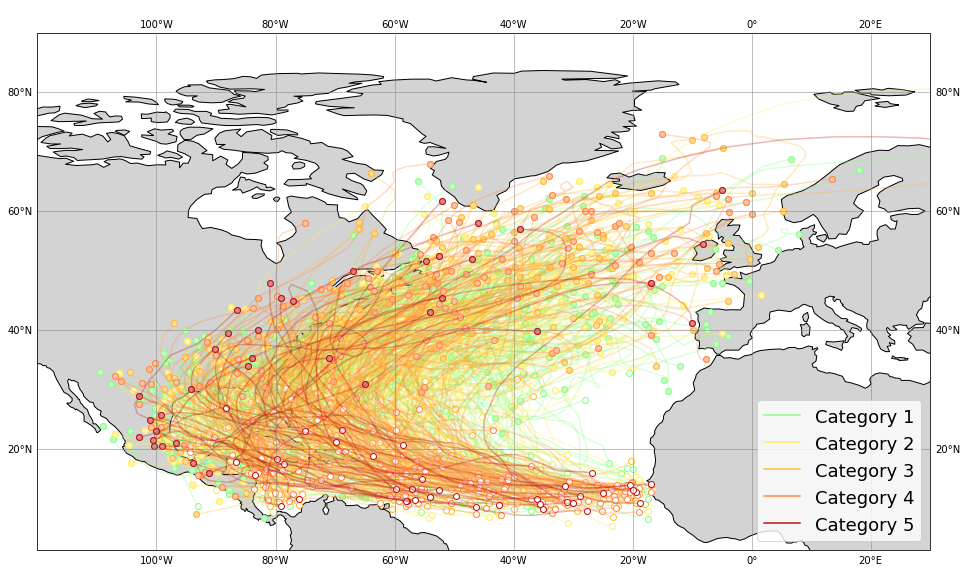

In [4]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='gray', alpha=0.5, draw_labels=True)
for cat, hurrs in hurricanes.items():
    ax = plot_2d(hurrs, legend=False, color=COLORS[cat - 1], alpha=0.3, show=False)

ax.update({"xlabel": "lat", "ylabel": "lon"})
ax.set_extent([-120, 30, 20, 50])
ax.legend(handles=[
    plt.plot([], [], color=color, label=f"Category {cat}")[0]
    for color, cat in zip(COLORS, CATEGORIES)
], loc=4, fontsize=18)
plt.show()

## 5. Data distribution

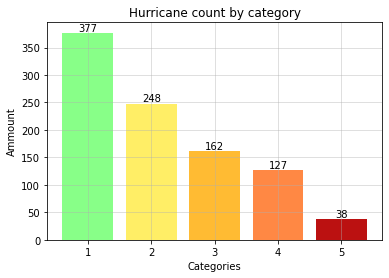

In [5]:
counts = list(map(len, hurricanes.values()))

_, ax = plt.subplots()
bars = ax.bar(CATEGORIES, counts, color=COLORS)
plt.bar_label(bars)
plt.xlabel("Categories")
plt.ylabel("Ammount")
plt.title("Hurricane count by category")
plt.grid(alpha=0.5)
plt.show()

## 6. Duration analysis

The duration of the hurricanes can be inspected by substracting the first time record from the last one. Although there is not a huge difference, data shows how the duration of the hurricanes is slightly related to their intensity.

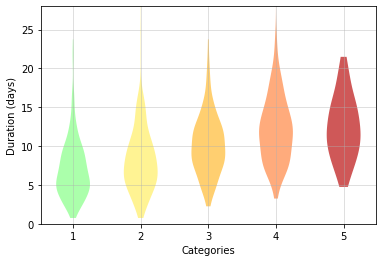

In [6]:
for cat, hurrs in hurricanes.items():
    durations = [(traj.t[-1] - traj.t[0]) / (3600 * 24) for traj in hurrs]
    _d = plt.violinplot(durations, positions=[cat], showextrema=False)
    _d["bodies"][0].set_facecolor(COLORS[cat - 1])
    _d["bodies"][0].set_alpha(0.7)

plt.xticks(CATEGORIES)
plt.ylim(0, 28)
plt.ylabel("Duration (days)")
plt.xlabel("Categories")
plt.grid(alpha=0.5)

## 7. Initial latitudes analysis

By inspecting trajectories initial points (white dots in the spacial plots), we noticed that many hurricanes started their path in lower latitudes. We can gather this data by simply taking the first element of the longitude dimension of every trajectory (`traj.r.y[0]`). We can corroborate that hurricanes with higher intensity tend to start their path in lower latitudes.

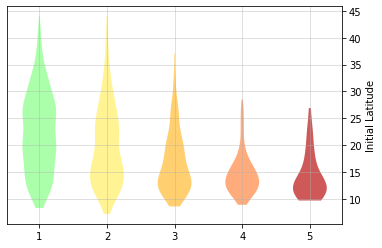

In [7]:
init_lats_by_cat = []
for cat, hurrs in hurricanes.items():
    init_lats_by_cat.append([traj.r.y[0] for traj in hurrs])
    _d = plt.violinplot(init_lats_by_cat[-1], positions=[cat], showextrema=False)
    _d["bodies"][0].set_facecolor(COLORS[cat - 1])
    _d["bodies"][0].set_alpha(0.7)

plt.ylabel("Initial Latitude")
plt.grid(alpha=0.5)
plt.xticks(CATEGORIES)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()